经典卷积神经网络的基本组成部分是下面的这个序列：
1. 带填充以保持分辨率的卷积层；
2. 非线性激活函数，如ReLU；
3. 汇聚层，如最大汇聚层。
而一个VGG块与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs,in_channels,out_channels):
    layers=[]
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

VGG神经网络连接 图7.2.1的几个VGG块（在vgg_block函数中定义）。其中有超参数变量conv_arch。该变量
指定了每个VGG块里卷积层个数和输出通道数。全连接模块则与AlexNet中的相同。
原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。第一个模块有64个
输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接
层，因此它通常被称为VGG‐11。

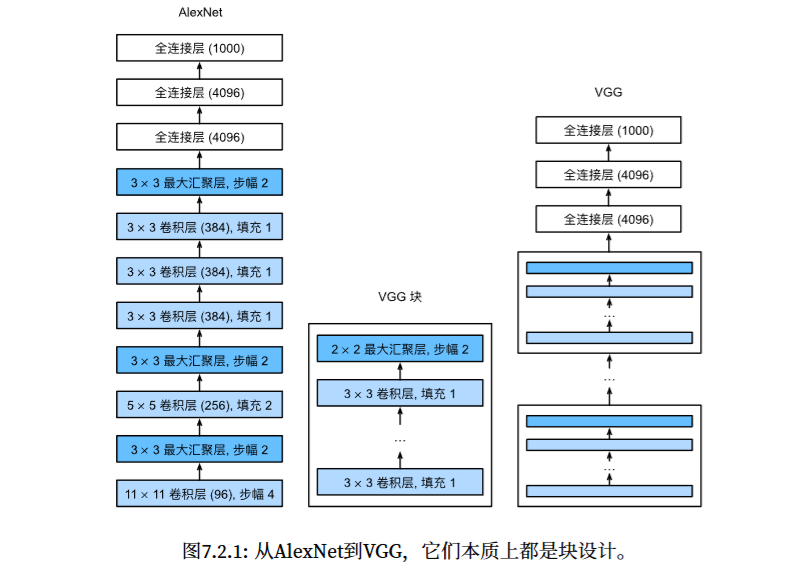

In [2]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [3]:
#VGG_11的实现
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

net = vgg(conv_arch)

In [4]:
#构建样本：高、宽都是224的单通道数据样本，观察每层输出的形状
X=torch.randn(size=(1,1,224,224))
for blk in net:
    X=blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
#训练模型
#由于VGG‐11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion‐MNIST数据集。
ratio=4     #通道数缩小比例
small_conv_arch=[(pair[0],pair[1]//ratio) for pair in conv_arch]
net=vgg(small_conv_arch)

loss 0.112, train acc 0.958, test acc 0.923
812.7 examples/sec on cuda:0


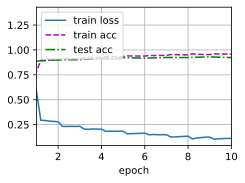

In [7]:
lr,num_epochs,batch_size=0.05,10,12
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=224)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())